In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from prettytable import PrettyTable
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('Reviews.csv')
data = df

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#Removing Neural reviews
data_s = data[data['Score']!=3]

#Updating Score to 0 or 1
def partition(x):
    if x<3:
        return 0
    return 1

score_upd = data_s['Score']
temp = score_upd.map(partition)
data_s['Score'] = temp

In [5]:
final_data = data_s.drop_duplicates(subset=('UserId','ProfileName','Time','Text'))
final = final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]

In [6]:
final = final.sort_values(['Time'], axis=0)   #TIme based sorting
final = final.head(100000)
final_X = final['Text']
final_y = final['Score']

In [7]:
import re
temp_1 =[]
snow = nltk.stem.SnowballStemmer('english')
i = 0
N = len(final_X)
for sentence in final_X:
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]        #Splitting the words
    temp_1.append(words)                                                                            # and doing stemming
    print("{0:.2f} %".format((i/N)*100),end ='\r')
    i = i+1
    
final_X = temp_1 

In [8]:
sent = []
for row in final_X:
    seq = ''
    for word in row:
        seq = seq + ' ' + word
    sent.append(seq)

final_X = sent

In [9]:
final_y.value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [10]:
X_train = final_X[:70000]
X_test = final_X[70000:]
y_train = final_y[:70000]
y_test = final_y[70000:]

** BOW vectorizer **

In [226]:
# Bag of Words

count_vect = CountVectorizer(max_features = 2000)
bow_X_train = count_vect.fit_transform(X_train)
bow_X_test = count_vect.transform(X_test)

** GRIDSEARCHCV **

In [227]:
depth = [i for i in range(20,60,4)]
clf = DecisionTreeClassifier(class_weight ='balanced')
param_grid = {'max_depth':depth}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 56}
Accuracy on train data =  82.52000000000001


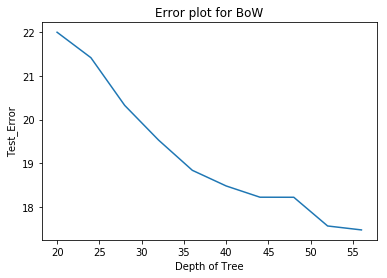

In [228]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(depth, error)
plt.title('Error plot for BoW')
plt.xlabel('Depth of Tree')
plt.ylabel('Test_Error')
plt.show()

In [229]:
optimal_depth = a.get('max_depth')
print(optimal_depth)

56


In [230]:
clf = DecisionTreeClassifier(max_depth = optimal_depth,class_weight = 'balanced')

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=82.136667%

precision=92.607036%

recall=86.188656%

F1-Score=89.282643%


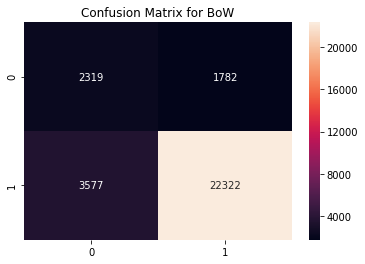

In [231]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

In [232]:
negative_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[0:10]
positive_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[1990:2000]

In [233]:
neg={}
pos={}
for index in negative_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            neg[i]=clf.feature_importances_[index]
            
for index in positive_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            pos[i]=clf.feature_importances_[index]

In [234]:
pos

{'bad': 0.015984613447138377,
 'best': 0.0392048370812338,
 'delici': 0.025187115591155985,
 'disappoint': 0.03317057942526244,
 'excel': 0.014888644888979464,
 'good': 0.015447898194900361,
 'great': 0.0639857476486451,
 'love': 0.031907262676051894,
 'perfect': 0.015186006551740567,
 'tast': 0.012717093171152868}

In [235]:
print("Negative Words Are=")
neg

Negative Words Are=


{'fact': 0.0,
 'freezer': 0.0,
 'french': 0.0,
 'frequent': 0.0,
 'fri': 0.0,
 'front': 0.0,
 'frost': 0.0,
 'frozen': 0.0,
 'relax': 0.0,
 'remain': 0.0}

In [236]:
import graphviz
from sklearn import tree

In [237]:
voc = count_vect.vocabulary_

ind=list(voc.values())
indexes = np.array(ind).argsort()

words=list(voc.keys())
sorted_words=[]
for i in indexes:
    sorted_words.append(words[i])

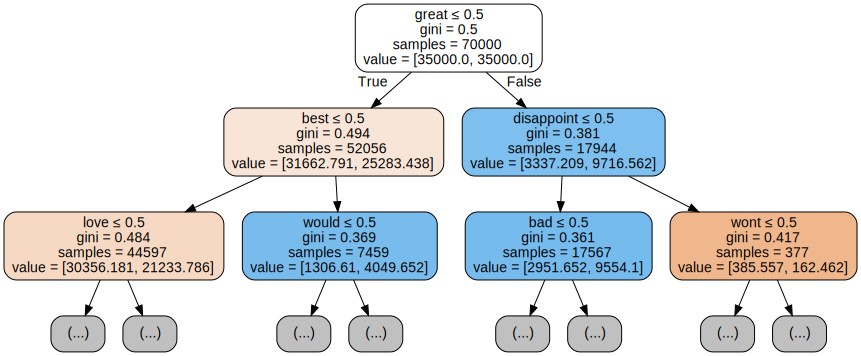

In [238]:
dot_data = tree.export_graphviz(clf, out_file=None,max_depth=2,  
                         filled=True, rounded=True,feature_names=sorted_words,
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

** TF_IDF Vectorizer **

In [198]:
tf_idf = TfidfVectorizer(max_features=2000)
tf_X_train = tf_idf.fit_transform(X_train)
tf_X_test = tf_idf.transform(X_test)

** GRIDSEARCHCV **

In [199]:
depth = [i for i in range(20,60,4)]
clf = DecisionTreeClassifier(class_weight ='balanced')
param_grid = {'max_depth':depth}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 56}
Accuracy on train data =  82.03714285714285


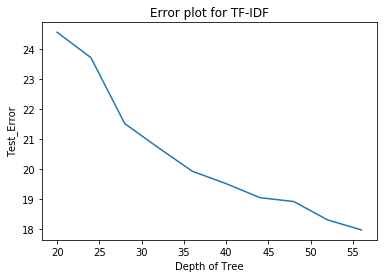

In [200]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(depth, error)
plt.title('Error plot for TF-IDF')
plt.xlabel('Depth of Tree')
plt.ylabel('Test_Error')
plt.show()

In [201]:
optimal_depth2 = a.get('max_depth')
print(optimal_depth2)

56


In [202]:
clf = DecisionTreeClassifier(max_depth = optimal_depth2,class_weight = 'balanced')

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=81.233333%

precision=92.988335%

recall=84.644195%

F1-Score=88.620285%


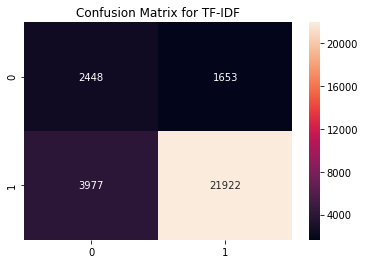

In [203]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF')
plt.show()

In [204]:
negative_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[0:10]
positive_log = np.array(list(map(abs,clf.feature_importances_))).argsort()[1990:2000]

neg={}
pos={}
for index in negative_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            neg[i]=clf.feature_importances_[index]
            
for index in positive_log:
    for i in count_vect.vocabulary_:
        if count_vect.vocabulary_[i] == index:
            pos[i]=clf.feature_importances_[index]

print("Positive Words")
pos
print("Negative Words")
neg

Positive Words
Negative Words


{'grape': 0.0,
 'grass': 0.0,
 'gravi': 0.0,
 'greatest': 0.0,
 'greeni': 0.0,
 'seafood': 0.0,
 'seattl': 0.0,
 'secret': 0.0,
 'section': 0.0,
 'zero': 0.0}

{'best': 0.04217391961847863,
 'delici': 0.02892158440591705,
 'disappoint': 0.03250226457707443,
 'excel': 0.01610340233653305,
 'favorit': 0.015147336910230864,
 'good': 0.02171696152283509,
 'great': 0.07320446958728878,
 'love': 0.03933777522915673,
 'perfect': 0.017033938809374198,
 'tast': 0.014114737109052294}

In [205]:
voc = count_vect.vocabulary_

ind=list(voc.values())
indexes = np.array(ind).argsort()

words=list(voc.keys())
sorted_words=[]
for i in indexes:
    sorted_words.append(words[i])

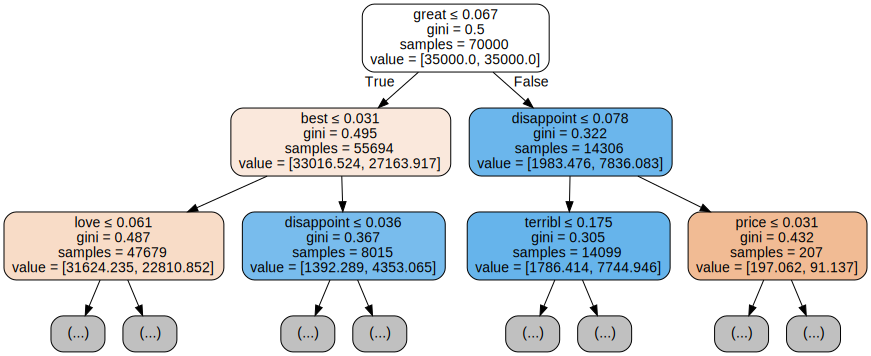

In [206]:
dot_data = tree.export_graphviz(clf, out_file=None,max_depth=2,  
                         filled=True, rounded=True,feature_names=sorted_words,
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

** AVG W2V Vectorizer **

In [208]:
w2v_data = X_train

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_train = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    avg_X_train.append(vec/count)
    
#================================================================
w2v_data = X_test

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_test = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    if count==0:
        avg_X_test.append(vec)
    else:
        avg_X_test.append(vec/count)

** GridSearchCV **

In [209]:
depth = [i for i in range(20,60,4)]
clf = DecisionTreeClassifier(class_weight ='balanced')
param_grid = {'max_depth':depth}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(avg_X_train, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 44}
Accuracy on train data =  84.71142857142857


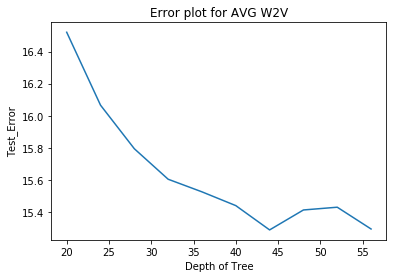

In [210]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(depth, error)
plt.title('Error plot for AVG W2V')
plt.xlabel('Depth of Tree')
plt.ylabel('Test_Error')
plt.show()

In [211]:
optimal_depth3 = a.get('max_depth')
print(optimal_depth3)

44


In [212]:
clf = DecisionTreeClassifier(max_depth = optimal_depth3,class_weight = 'balanced')

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc3 = accuracy_score(y_test, pred) * 100
pre3 = precision_score(y_test, pred) * 100
rec3 = recall_score(y_test, pred) * 100
f13 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc3))
print('\nprecision=%f%%' % (pre3))
print('\nrecall=%f%%' % (rec3))
print('\nF1-Score=%f%%' % (f13))


Accuracy=83.903333%

precision=86.907932%

recall=95.783621%

F1-Score=91.130173%


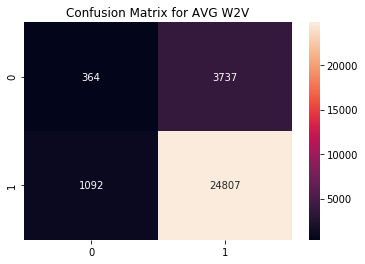

In [213]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for AVG W2V')
plt.show()

In [214]:
del avg_X_train
del avg_X_test

** TF_IDF W2V Vectorizer **

In [215]:
tf_w_data = X_train
tf_idf = TfidfVectorizer(max_features=5000)
tf_idf_data = tf_idf.fit_transform(tf_w_data)
tf_train_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    #print(vec)
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_train_data.append(vec)
    i = i + 1
    
    
    
#====================================================================================

tf_w_data = X_test
tf_idf_data = tf_idf.transform(tf_w_data)
tf_test_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_test_data.append(vec)
    i = i + 1

** GridSearchCV **

In [216]:
depth = [i for i in range(20,60,4)]
clf = DecisionTreeClassifier(class_weight ='balanced')
param_grid = {'max_depth':depth}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(tf_train_data, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 44}
Accuracy on train data =  83.67857142857143


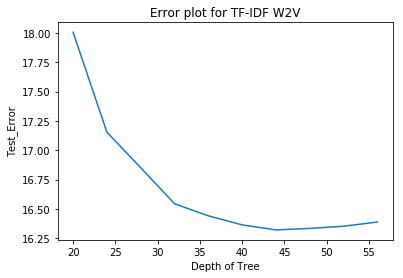

In [217]:
error = [(1-i)*100 for i in grid.cv_results_['mean_test_score']]
plt.plot(depth, error)
plt.title('Error plot for TF-IDF W2V')
plt.xlabel('Depth of Tree')
plt.ylabel('Test_Error')
plt.show()

In [218]:
optimal_depth4 = a.get('max_depth')
print(optimal_depth4)

44


In [219]:
clf = DecisionTreeClassifier(max_depth = optimal_depth3,class_weight = 'balanced')

clf.fit(tf_train_data,y_train)

pred = clf.predict(tf_test_data)

acc4 = accuracy_score(y_test, pred) * 100
pre4 = precision_score(y_test, pred) * 100
rec4 = recall_score(y_test, pred) * 100
f14 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc4))
print('\nprecision=%f%%' % (pre4))
print('\nrecall=%f%%' % (rec4))
print('\nF1-Score=%f%%' % (f14))


Accuracy=82.626667%

precision=89.312455%

recall=90.733233%

F1-Score=90.017238%


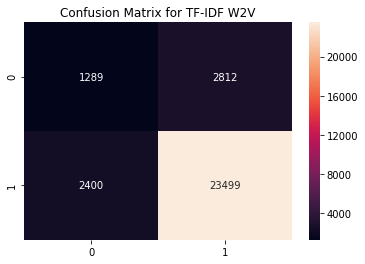

In [220]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF W2V')
plt.show()

In [221]:
del tf_train_data
del tf_test_data

In [222]:
x = PrettyTable()

model1 = 'BoW'
model2 = 'TF-IDF'
model3 = 'AVG W2V'
model4 = 'TF-IDF W2V'

x.field_names = ["Model","Tree Depth","Test_Acc(%)","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

acc1 = np.around(acc1, decimals = 2)
err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

acc2 = np.around(acc2, decimals = 2)
err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12= np.around(f12, decimals = 2)

acc3 = np.around(acc3, decimals = 2)
err3 = np.around(100-acc3, decimals = 2) 
pre3 = np.around(pre3, decimals = 2)
rec3 = np.around(rec3, decimals = 2)
f13= np.around(f13, decimals = 2)

acc4 = np.around(acc4, decimals = 2)
err4 = np.around(100-acc4, decimals = 2) 
pre4 = np.around(pre4, decimals = 2)
rec4 = np.around(rec4, decimals = 2)
f14 = np.around(f14, decimals = 2)

x.add_row([model1,optimal_depth,acc1,err1,pre1,rec1,f11])
x.add_row([model2,optimal_depth2,acc2,err2,pre2,rec2,f12])
x.add_row([model3,optimal_depth3,acc3,err3,pre3,rec3,f13])
x.add_row([model4,optimal_depth4,acc4,err4,pre4,rec4,f14])

print(x)

+------------+------------+-------------+---------------+--------------+-----------+-------------+
|   Model    | Tree Depth | Test_Acc(%) | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------------+------------+-------------+---------------+--------------+-----------+-------------+
|    BoW     |     56     |    81.93    |     18.07     |    92.57     |   85.96   |    89.14    |
|   TF-IDF   |     56     |    81.23    |     18.77     |    92.99     |   84.64   |    88.62    |
|  AVG W2V   |     44     |     83.9    |      16.1     |    86.91     |   95.78   |    91.13    |
| TF-IDF W2V |     44     |    82.63    |     17.37     |    89.31     |   90.73   |    90.02    |
+------------+------------+-------------+---------------+--------------+-----------+-------------+


** Observations and Summary **

* Considered 100k datapoints for running this model
* To find optimal depth of tree used GridSearchCV and shown in table format using prettytable.
* Used all metrics systems to have a depth look of what happening to data predictions.
* Used Pretty table to show all the data in a table format so that user can understand whats going on with every model.
* I see that AVG W2V model gave best accuracy compared to other models.